# Exam Project

In [1]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import glob
import random
import bs4
import requests
import time

#witch size to resize to
pixel_x = 64
pixel_y = 64


#Training and testing data location
trainingdata= glob.glob('./TraningData/*.jpg')
testingdata= glob.glob('./TestingData/*.jpg')

In [2]:
def getTestingData(array, list, x=120, y=50):
    print("Preparing testing images")
    tmp_testing_images = []
    tmp_testing_labels = []
    class_names = array 
    
    shuffled_list = random.sample(list, len(list))
    

    for i in shuffled_list:
        object_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
        resized_img = cv.resize(cv.imread(i), (x, y))
        resized_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
        tmp_testing_images.append(resized_img)
        index = class_names.index(object_name)
        tmp_testing_labels.append(index)
    #Transforms arrays to numpy arrays        
    testing_images = np.asarray(tmp_testing_images).reshape(len(list) , x, y, 1)
    testing_labels = np.asarray(tmp_testing_labels)
                              
    return testing_images, testing_labels


def getData(list, x=120, y=50):
    print("Preparing training images")
    tmp_training_images = []
    tmp_training_labels = []
    class_names = []
    
    shuffled_list = random.sample(list, len(list))
    
    
    
    for i in shuffled_list:
        resized_img = cv.resize(cv.imread(i), (x, y))
        resized_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
        
        tmp_training_images.append(resized_img)
        
        object_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
        #If car (object_name) exists in class_names
        if object_name in class_names:
            #Take index of that car (object_name) in class_names and append it to tmp_training_labels
            index = class_names.index(object_name)
            tmp_training_labels.append(index)
        else:
            #Append car (object_name) to class_names, take index of car (object_name) in class_names, append index to tmp_training_labels 
            class_names.append(object_name)
            index = class_names.index(object_name)
            tmp_training_labels.append(index)
            
    #Transforms arrays to numpy arrays        
    training_images = np.asarray(tmp_training_images).reshape(len(list) , x, y, 1)
    training_labels = np.asarray(tmp_training_labels)
                               
    return training_images, training_labels, class_names

In [16]:


training_images, training_labels, class_names = getData(trainingdata, pixel_x, pixel_y) ## Skal skiftes ud til vores dataset
testing_images, testing_labels = getTestingData(class_names, testingdata, pixel_x, pixel_y)
training_images, testing_images = training_images / 255, testing_images / 255 # preparing the data

print(class_names)


#model = models.Sequential()
#model.add(layers.Conv2D(64, (3,3), activation= "relu", input_shape=(pixel_x, pixel_y, 1)))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(128, (3,3), activation= "relu"))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(256, (5,5), activation= "relu"))
#model.add(layers.Flatten())
#model.add(layers.Dense(512, activation = "relu"))
#model.add(layers.Dense(len(class_names), activation = "softmax"))

#model.summary()




#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.fit(training_images, training_labels, epochs=25, validation_data=(testing_images, testing_labels))
#loss, accuracy = model.evaluate(testing_images, testing_labels)

#print(f'Loss: {loss}')
#print(f"Accuracy: {accuracy}")
#model.save('car_classifier.model')


Preparing training images
Preparing testing images
['fiat 500', 'audi R8']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 256)       819456    
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_____________________________________________

In [18]:
def predict(image, pixel_x=64, pixel_y=64):
    print("I Think this is a ....")
    model = models.load_model('car_classifier.model') 

    img = cv.imread(image)
    img_root = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    class_names = ["Fiat 500", "Audi R8"]
    img = cv.resize(img_root, (pixel_x, pixel_y))
    prediction = model.predict(np.array([img]).reshape(1, pixel_x, pixel_y, 1) / 255)
    index = np.argmax(prediction)
    print(f'{class_names[index]}, defenently a {class_names[index]}')
    return class_names[index]

In [19]:
def find_car(predict):
    print("Finding you a new car")
    
    try:
        original_url = 'https://www.bilbasen.dk'
        options = Options()
        options.headless = True
        browser = webdriver.Firefox(options = options)

        browser.get(original_url)
        browser.implicitly_wait(5)
        popUpButton = browser.find_element_by_id("onetrust-accept-btn-handler")
        popUpButton.click()
        searchBar = browser.find_element_by_class_name('react-autosuggest__input')
        searchBar.send_keys(predict)
        searchBar.send_keys(Keys.RETURN)
        
        boolean_check_for_next = True
        time.sleep(5)
        url_array = []

        while boolean_check_for_next:
            url_array.append(browser.current_url) 
            try:
                if browser.find_element_by_class_name("next"):
                    browser.find_element_by_class_name("next").click()
            except:
                boolean_check_for_next = False
        car_price = []
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        print("Here they come!!")
        for url in url_array:
            url = url.replace("includeleasing=true", "includeleasing=false")
            url = url.replace("includeLeasing=true", "includeLeasing=false")
            req = requests.get(url, headers=headers)
            soup = bs4.BeautifulSoup(req.text, 'html.parser')
            mydivs = soup.find_all("div", {"class": "row listing listing-plus bb-listing-clickable"})

            
            for car in mydivs:

                price = car.find("div", {"class" : "col-xs-3 listing-price"}).text
                data = car.find_all("div", {"class" : "col-xs-2 listing-data"})
                km = data[1].text
                year = data[2].text
                
                
                print(f'Bil: {predict}')
                if price == "Ring":
                    print(f'Pris: Ring')
                else:
                    price = price.split(' ')[0].split('.')
                    print(f'Pris: {price[0]+price[1]}')
                print(f'År: {year}')
                print(f'Km: {km}')
                print(f'-------------')
                car_price.append(price[0]+price[1])
        print("All Done!")
        print(" ")
    finally:
        browser.quit()

In [21]:
find_car(predict("./TestingData/FIAT_500_8.jpg"))




I Think this is a ....
Fiat 500, defenently a Fiat 500
Finding you a new car
Here they come!!
Bil: Fiat 500
Pris: 124800
År: 2017
Km: 40.000
-------------
Bil: Fiat 500
Pris: 169995
År: 2018
Km: 32.000
-------------
Bil: Fiat 500
Pris: 99900
År: 2017
Km: 58.000
-------------
Bil: Fiat 500
Pris: 73900
År: 2014
Km: 57.000
-------------
Bil: Fiat 500
Pris: 104900
År: 2015
Km: 41.000
-------------
Bil: Fiat 500
Pris: 69000
År: 2011
Km: 100.000
-------------
Bil: Fiat 500
Pris: 179800
År: 2019
Km: 9.000
-------------
Bil: Fiat 500
Pris: 159800
År: 2019
Km: 6.000
-------------
Bil: Fiat 500
Pris: 92500
År: 2016
Km: 51.000
-------------
Bil: Fiat 500
Pris: 129995
År: 2021
Km: 0
-------------
Bil: Fiat 500
Pris: 242900
År: 2020
Km: 0
-------------
Bil: Fiat 500
Pris: 79900
År: 2014
Km: 72.000
-------------
Bil: Fiat 500
Pris: 57500
År: 2010
Km: 124.000
-------------
Bil: Fiat 500
Pris: 119800
År: 2019
Km: 20.000
-------------
Bil: Fiat 500
Pris: 69500
År: 2012
Km: 71.000
-------------
Bil: Fia

Bil: Fiat 500
Pris: 174900
År: 2019
Km: 1.000
-------------
Bil: Fiat 500
Pris: 39900
År: 2009
Km: 175.000
-------------
Bil: Fiat 500
Pris: 159880
År: 2020
Km: 14.000
-------------
Bil: Fiat 500
Pris: 127900
År: 2019
Km: 15.000
-------------
Bil: Fiat 500
Pris: 189900
År: 2019
Km: 62.000
-------------
Bil: Fiat 500
Pris: 38000
År: 2008
Km: 152.000
-------------
Bil: Fiat 500
Pris: 34900
År: 2008
Km: 161.000
-------------
Bil: Fiat 500
Pris: 59900
År: 2008
Km: 112.000
-------------
Bil: Fiat 500
Pris: 71900
År: 2008
Km: 30.000
-------------
Bil: Fiat 500
Pris: 229900
År: 2021
Km: 5.000
-------------
Bil: Fiat 500
Pris: 94800
År: 2017
Km: 49.000
-------------
Bil: Fiat 500
Pris: 129900
År: 2016
Km: 50.000
-------------
Bil: Fiat 500
Pris: 39900
År: 2011
Km: 147.000
-------------
Bil: Fiat 500
Pris: 283090
År: 2021
Km: 0
-------------
Bil: Fiat 500
Pris: 59900
År: 2012
Km: 55.000
-------------
Bil: Fiat 500
Pris: 36500
År: 2008
Km: 199.000
-------------
Bil: Fiat 500
Pris: 54900
År: 2012

Prediction is audi R8
Car is: fiat 500
Prediction is False


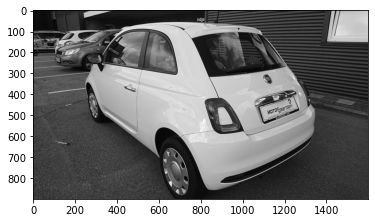

-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: fiat 500
Prediction is False


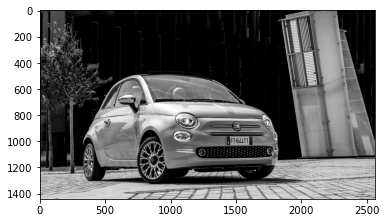

-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: fiat 500
Predi

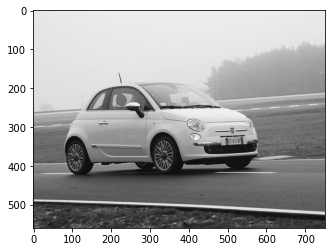

-------------------
Prediction is fiat 500
Car is: audi R8
Prediction is False


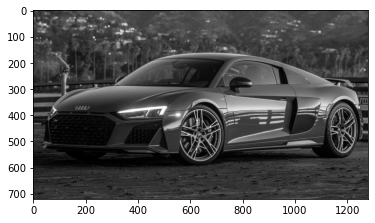

-------------------
Prediction is fiat 500
Car is: audi R8
Prediction is False


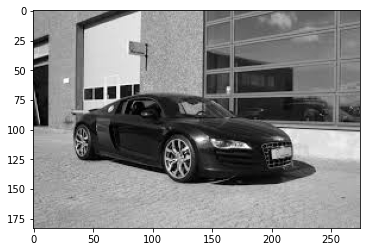

-------------------
Prediction is fiat 500
Car is: fiat 500
Prediction is True
-------------------
Prediction is audi R8
Car is: audi R8
Prediction is True
-------------------
Rigtige gæt: 75.0%
5
15


In [17]:
#Test af model

model = models.load_model('car_classifier.model')
accuracy = []
img_array = testingdata

random.shuffle(img_array)

for i in img_array:
    img_name = os.path.basename(i).split('_')[0].lower() + " " + os.path.basename(i).split('_')[1]
    
    img = cv.imread(i)
    img_root = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img = cv.resize(img_root, (pixel_x, pixel_y))
    prediction = model.predict(np.array([img]).reshape(1, pixel_x, pixel_y, 1) / 255)
    index = np.argmax(prediction)
    print(f'Prediction is {class_names[index]}')
    print(f'Car is: {img_name}')
    if class_names[index] == img_name:
        print(f'Prediction is True')
        accuracy.append(True)
    else:
        print(f'Prediction is False')
        plt.imshow(img_root, cmap=plt.cm.gray)
        plt.show()
        accuracy.append(False)
    print('-------------------')
print(f'Rigtige gæt: {100 - (accuracy.count(False)/len(img_array))*100}%')
print(accuracy.count(False))
print(accuracy.count(True))

In [8]:
"""
def resize(imgs):
    print(imgs)
    for i in imgs:
        img = cv.imread(i)
        resize_img = cv.resize(img, (32, 32))
        cv.imwrite(i, resize_img)
resize(imgs)
"""

'\ndef resize(imgs):\n    print(imgs)\n    for i in imgs:\n        img = cv.imread(i)\n        resize_img = cv.resize(img, (32, 32))\n        cv.imwrite(i, resize_img)\nresize(imgs)\n'